# 06. PyTorch Transfer Learning

What is transfer learning ?

Thransfer learning involves taking the parameters from the one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)  # want 1.12+
print(torchvision.__version__) # want 0.13+

1.12.1
0.13.1


Let's import the code we've written in privious section so that we don't have to write it all again.

In [2]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

## 1 Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [3]:
import os
import zipfile 

from pathlib import Path

import requests

# setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # image from a subset of classes from the Food101 dataset

if image_path.is_dir():
    print(f"{image_path} directory exist, skipping re-download.")
else:
    print(f"Did not find {image_path}, downloading it....")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Downloading pizz, steak, shushi data
    with open(data_path / "pizza_steak_shushi.zip", "wb") as f:
        request = requests.get("put URL...")
        f.write(request.content)
    
    # Unzip 
    with zipfile.ZipFile(data_path/"pizza_steak_shushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exist, skipping re-download.


In [4]:
# setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create Dataset and Dataloaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use 'data_setup.py' and the 'create_dataloaders()' function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: How to **transforms** it ?

And with 'torchvision' 0.13+ ther's two to do this:

    1. Manulally created transforms - you define what transforms you want your data to go through.
    2. Automatically created transforms - the transfroms for your data are define by the model you'd like to use.
 
Important point: when using a pretrained model, important that the data (including your custom data) that you pass through it is **trasnformed** in the same way that the data the model was trained on.

In [5]:
from going_modular import data_setup

### 2.1 Creating a transform for 'torchvision.model' (manual creation)

**torchvision.models** contains pretrained models

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [6]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize]) # make sure image have the same distribution an ImageNet (where our pretrained model have been trained)

In [7]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e8170fc760>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating transforms for 'tochvision.model' (auto creation)

As of **torchvision v0.13+** there is now support for automatic data creation based on the pretrained model weights your using.

In [8]:
import torchvision
torchvision.__version__

'0.13.1'

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create DataLoader using automatic trasforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e8170fc880>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
    
    1. Pytorch domain libraries
    
    2. Libraries like "time" (torch image model)
    
    3. HuggingFace Hub (for planty of defferent models)

    4. Paperwithcode (for model across diffrent problem space/domains)

### 3.1 Which pretraind model should you use ?

* Experiment, experiment, experiment! *

Three things to consider:
1. Speed
2. Size
3. Performace

### 3.2 Setting up a pretrained model

want to create an instance of a pretrainded EfficientNet_b0

In [12]:
# OLD method of creating a pretraind model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creting a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with 'torchinfo.summary()'

In [14]:
# print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=[1,3,224,224], # [batch_size, color_channel, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

In [15]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
# Freeze all of the base layers in EffNet_B0
for param in model.features.parameters():
    #print(param)
    param.requires_grad = False

In [17]:
# update all of the base layers in EffNetB0
from torch import nn

# torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,  # feature vector coming in
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(model=model,
        input_size=[1,3,224,224], # [batch_size, color_channel, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4 Train model

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [95]:
# Import train function
from going_modular import engine

# set the manual seed
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end timer
end_time = timer()
print(f"Total training time: {end_time - start_time:3f} seconds ")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5529 | train_acc: 0.9102 | test_loss: 0.5726 | test_acc: 0.8352
Epoch: 2 | train_loss: 0.5507 | train_acc: 0.7891 | test_loss: 0.5569 | test_acc: 0.8551
Epoch: 3 | train_loss: 0.4723 | train_acc: 0.9297 | test_loss: 0.5201 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.5289 | train_acc: 0.8164 | test_loss: 0.5295 | test_acc: 0.7841
Epoch: 5 | train_loss: 0.4488 | train_acc: 0.9219 | test_loss: 0.4376 | test_acc: 0.8759
Total training time: 267.034904 seconds 


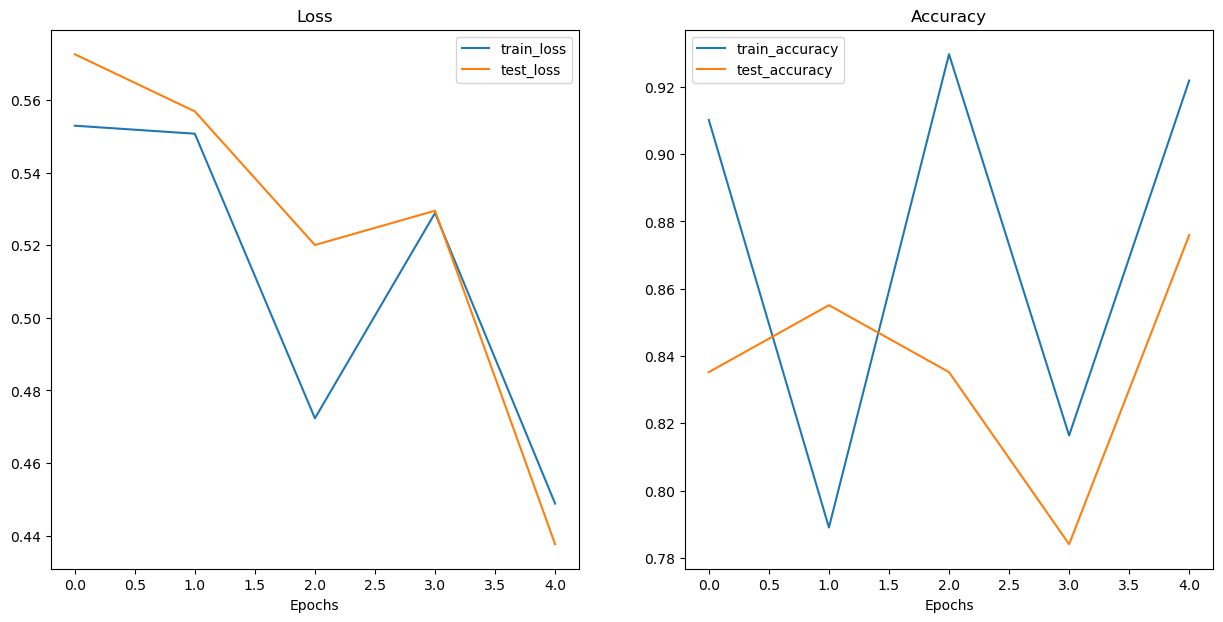

In [96]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 6. Make prediction on images from the test set

We have to make sure that our test/custom data is:
* Same shape - image need to be same shape as model was trained on
* same datatype 
* Same device 
* Same transform

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transforms and target device
2. Open the image with 'PIL.Image.Open'
3. Create a transforms if it doesn't exist
4. Make sure the model is on same device
5. Turn the model on 'model.eval()' model to make sure it is ready for inference (this is turn off things like 'nn.Dropour()')
6. Transforms the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make prediction on image by passing to model 
8. convert logits -> prediction probability 'torch.softmax'
9. convert pred probs -> labels using 'torch.argmax'
10. Plot the image with `matplotlib` and set the title to prediction label from step 9 and prediction prob from step 8. 

In [97]:
from typing import List, Tuple 

from PIL import Image

from torchvision import transforms
import matplotlib.pyplot as plt

#1. Take in a trained model....
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    # 2. Open the image with PIL 
    img = Image.open(image_path)
    
    # 3. Create a tranforms if doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                                                transforms.Resize(image_size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                     std=[0.229, 0.224, 0.225])
        ])
        
    ### Predict on image ###
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on inferece mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension 
        transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels,h, w]
        
        # 7. Make a prediction on the transformed image by passing it to model (also ensure that it's on the target device)
        target_image_pred = model(transformed_image.to(device))
    
    # 8. logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    # 9. pred probs to labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 10. plot image with predicted label and probability
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

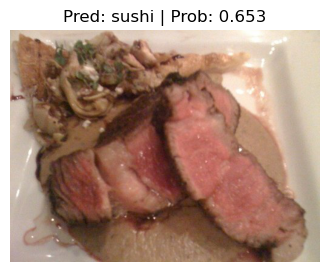

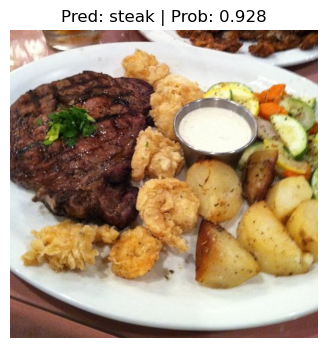

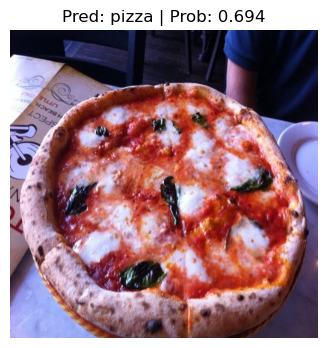

In [98]:
# Get random list of image path from test set
import random 
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_image_to_plot)

test_image_path_sample

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

### 6.1 Make prediction on custom image

In [99]:
data_path

WindowsPath('data')

In [100]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

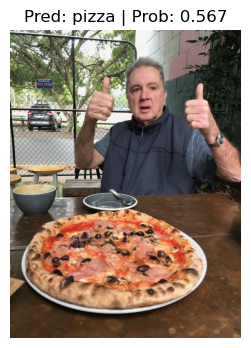

In [101]:
# predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)